# Coefficient Stability and R2
Julian Hsu
26 Aug 2021


Let's look at the Emily Oster paper of _Unobservable_selection_and_coefficient_stability:_theory_and_evidence_.  https://emilyoster.net/wp-content/uploads/UnobservableSelectionandCoefficientStabilityTheoryandEvidence.pdf

Use simulated data to plot the changes in coefficient and R2 as we add more and more features.

**Update 1-mar-2023** I see that the bias and coefficient estimate bounces around a lot. This is probably due to the relationship between the controlling variables changings signs. Although I order them from most the least relevant, I only look at the absolute value rather than the actual value.

Next steps to show this in practice are to allow the true DGP to be non-linear, and show whether the treatment effect asymptotically converges to the true treatment effect as we control for more things. This would allow us to make a recommendation that in practice we can use a "diminishing return" in the treatment effect as we control for more and more things.

In [48]:
os.getcwd()

'C:\\Users\\hjuli\\Documents\\GitHub\\statanomics\\workingcode\\diagnostics'

In [49]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

from matplotlib import gridspec
import matplotlib.pyplot as plt
%matplotlib inline  

import os as os
home = os.getcwd()
import diagnostics as dg
import stnomics as st
os.chdir(home)

In [50]:

def sim_data(K=10,excludeK=2):
    N = 5000
    T = 5
    df = pd.DataFrame( )

    ## Always leave "excludeK" that do not influence anything.
    K_matters = K - excludeK
    X = np.random.multivariate_normal(np.zeros(K_matters), np.eye(K_matters), N)
    
    for k in range(K_matters):
        df['x'+str(k)]= X[:,k]
    
    df['latentT'] = np.dot(X, np.random.uniform(1,4, K_matters))
    df['Y'] = np.dot(X, np.random.uniform(1,4, K_matters))    
    
    for k in range(excludeK):
        df['x_u'+str(k+K_matters)]= np.random.normal(0,1,N)
    
    df['T'] = ( np.exp(df['latentT'])/ (1 + np.exp(df['latentT'])) > np.random.uniform(0,1,N) ).astype(np.int32)
    df['Y'] += df['T']*T
    df['Y'] += np.random.normal(1,2,N)    
    

        
    return df


In [60]:
K = 10
df = sim_data(K=K,excludeK=2)
feature_list = [x for x in df if 'x' in x]
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
x0,5000.0,-0.006800,1.000461,-3.717984,-0.690708,-0.002501,0.683764,3.766606
x1,5000.0,-0.008037,0.990727,-3.656259,-0.675174,-0.000298,0.633015,3.501705
x2,5000.0,0.007997,1.001488,-3.344724,-0.664084,0.019404,0.663115,3.526634
x3,5000.0,0.006781,1.019048,-3.850993,-0.682949,0.005883,0.688195,3.874836
x4,5000.0,-0.004737,0.985289,-3.591556,-0.659676,-0.004639,0.662065,3.639495
x5,5000.0,0.017638,1.001490,-4.318084,-0.647661,0.011878,0.686038,4.025621
x6,5000.0,0.015269,1.003855,-3.587370,-0.659981,0.017782,0.685232,3.890490
x7,5000.0,0.023377,1.014980,-4.446072,-0.661306,0.041007,0.690529,3.515382
latentT,5000.0,0.112472,6.744824,-25.193727,-4.309261,0.123433,4.703432,22.708503
Y,5000.0,3.749710,9.423079,-24.515198,-3.531065,3.818188,10.927445,34.255860


When we plot the R2 and other metrics as we control for more stuff, we want a monotonic relationship. This means we need to order the features by most the least important. To that end, we create a function that selects the features most relevant to the outcome.

In [61]:
from sklearn.linear_model import LassoCV, Lasso, LogisticRegressionCV, LogisticRegression

class selection:

    def hdm_selection(data_est, 
                        feature_name, outcome_name, treatment_name):
        '''    
        data_set         (obj)    dataframe
        feature_name     (list)   list of features to choose from
        outcome_name     (str)    name of outcome in data_set
        treatment_name   (str)    name of treatment in data_set

        Run a cross-validated lasso regressions on the outcome and treatment to 
        select features that predict either or both.
        '''    
        selected_lasso_features = {}
        selected_lasso_features['treatment'] = []
        selected_lasso_features['outcome'] = []    
        selection_coeff_names = pd.DataFrame()
        for n,y in zip( ['outcome','treatment'], [outcome_name, treatment_name]):        
            if n=='outcome':
                lasso_selection = LassoCV(cv=5, random_state=27, normalize=True, n_jobs=-1).fit(data_est[feature_name], data_est[y]) 
                lasso_fit = Lasso(alpha=lasso_selection.alpha_, max_iter=200000).fit(data_est[feature_name], data_est[y]) 
            else:
                lasso_selection = LogisticRegressionCV(cv=5, random_state=27, penalty='l2', n_jobs=-1).fit(data_est[feature_name], data_est[y]) 
                lasso_fit = LogisticRegression(C=lasso_selection.C_[0], penalty='l2', max_iter=200000).fit(data_est[feature_name], data_est[y])             
            entry = pd.DataFrame(data={'type':n, 'features':feature_name, 'coef':lasso_fit.coef_.flatten()})
            selection_coeff_names = selection_coeff_names.append(entry)
            for x,b in zip(data_est[feature_name].columns, lasso_fit.coef_.flatten()):
                if (b != 0) & (x!='const') & (x !='t'):
                    selected_lasso_features[n].append(x)
                else:
                    pass
        unique_entries = list(selected_lasso_features.values())
        return unique_entries, selected_lasso_features, selection_coeff_names


In [62]:
fselect = dg.selection.hdm_selection(df, feature_list, 'Y','T')

C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\hjuli\Documents\GitHub\statanomics\workingcode\diagnostics\diagnostics.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selection_coeff_names = selection_coeff_names.append(entry)
C:\Users\hj

In [63]:
fselect_df = fselect[-1]
fselect_df['coef_abs'] = fselect_df['coef'].abs()
# print(fselect_df.loc[fselect_df['type']=='outcome'])
outcome_feature_list = fselect_df.loc[fselect_df['type']=='outcome'].sort_values('coef_abs',ascending=False)['features'].to_list()
treatment_feature_list = fselect_df.loc[fselect_df['type']=='treatment'].sort_values('coef_abs',ascending=False)['features'].to_list()

In [64]:
from sklearn.metrics import r2_score
def te_r2_output(te_model, te_model_dict_inputs,
                y_model):
    '''
    This function outputs treatment estimates, standard, and the R-squared from any general model.
    '''
    
    ## Call the treatment effect estimator
    te = te_model(te_model_dict_inputs['data_est'],
             te_model_dict_inputs['split_name'],
             te_model_dict_inputs['feature_name'],
             te_model_dict_inputs['outcome_name'],
             te_model_dict_inputs['treatment_name'],
             te_model_dict_inputs['ymodel'],
             te_model_dict_inputs['tmodel'],
             te_model_dict_inputs['n_data_splits'],
             te_model_dict_inputs['aux_dictionary'])

    yhat = st.predict_continuous(te_model_dict_inputs['data_est'],
                             te_model_dict_inputs['split_name'],
                             te_model_dict_inputs['n_data_splits'],
                             te_model_dict_inputs['feature_name'],
                             te_model_dict_inputs['outcome_name'],
                              y_model
                             )
    rsquared = r2_score( te_model_dict_inputs['data_est'][te_model_dict_inputs['outcome_name']], yhat)
    return te['ATE TE'], te['ATE SE'], rsquared




In [65]:
def ols_output(list_here):
    '''
    This function outputs treatment estimates, standard error, and the R-squared.
    Do cross splitting here, where we split the data into train/test sets, and calculate the r2 on the test set.
    '''
    random_partitions = 2
    df['splits'] = np.random.choice(random_partitions, len(df), replace=True)
    
    rsquared_output = 0
    for r in range(random_partitions):
        train = df.loc[df['splits']!=r]
        test = df.loc[df['splits']==r]
        model_on_train = sm.OLS(train['Y'],sm.add_constant(train[['T']+list_here]) ).fit()        
        model_predict_test = model_on_train.predict(sm.add_constant(test[['T']+list_here]) )        
        rsquared_output += np.sqrt(np.corrcoef( model_predict_test, test['Y'])[0,1]) / random_partitions
    model = sm.OLS(df['Y'],sm.add_constant(df[['T']+list_here]) ).fit()
    return model.params[1], model.bse[1], rsquared_output

iterative_ols_list = []
iterative_ols_coeff = []
iterative_ols_se = []
iterative_ols_rsquared = []
for f in outcome_feature_list:
    iterative_ols_list.append(f)
#     print(iterative_ols_list)
    a = ols_output(iterative_ols_list)
    iterative_ols_coeff.append(a[0])
    iterative_ols_se.append(a[1])
    iterative_ols_rsquared.append(a[2])
    

iterative_ols_coeff = np.array(iterative_ols_coeff)
iterative_ols_se = np.array(iterative_ols_se)
iterative_ols_rsquared = np.array(iterative_ols_rsquared)



In [66]:
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, LassoCV, LogisticRegressionCV

Now we will calculcate the treatment estimate, confidence interval, and $R^2$ when we control for different features.

In [67]:
ymodel = LassoCV(normalize=True, n_jobs=-1, max_iter= 5000)
tmodel = LogisticRegressionCV(n_jobs=-1, penalty='l1', solver='saga', max_iter= 5000)
te_model_dict_inputs = {
    'data_est': df,
    'split_name': 'splits',
    'n_data_splits': 5,
    'feature_name': feature_list,
    'outcome_name': 'Y',
    'treatment_name': 'T',
    'ymodel':ymodel,
    'tmodel':tmodel,
    'aux_dictionary': {'lower':0.001, 'upper': 0.999}
}


iterative_ml_list = []
iterative_ml_coeff = []
iterative_ml_se = []
iterative_ml_rsquared = []
for f in outcome_feature_list:
    iterative_ml_list.append(f)
    te_model_dict_inputs['feature_name'] = iterative_ml_list
    a = te_r2_output(st.ate.dml.dml_plm, te_model_dict_inputs,
                    ymodel)
    iterative_ml_coeff.append(a[0])
    iterative_ml_se.append(a[1])
    iterative_ml_rsquared.append(a[2])
    

iterative_ml_coeff = np.array(iterative_ml_coeff)
iterative_ml_se = np.array(iterative_ml_se)
iterative_ml_rsquared = np.array(iterative_ml_rsquared)



C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

f

C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

f

C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

f

C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

f

C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

f

C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

f

C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

f

C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

f

C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

f

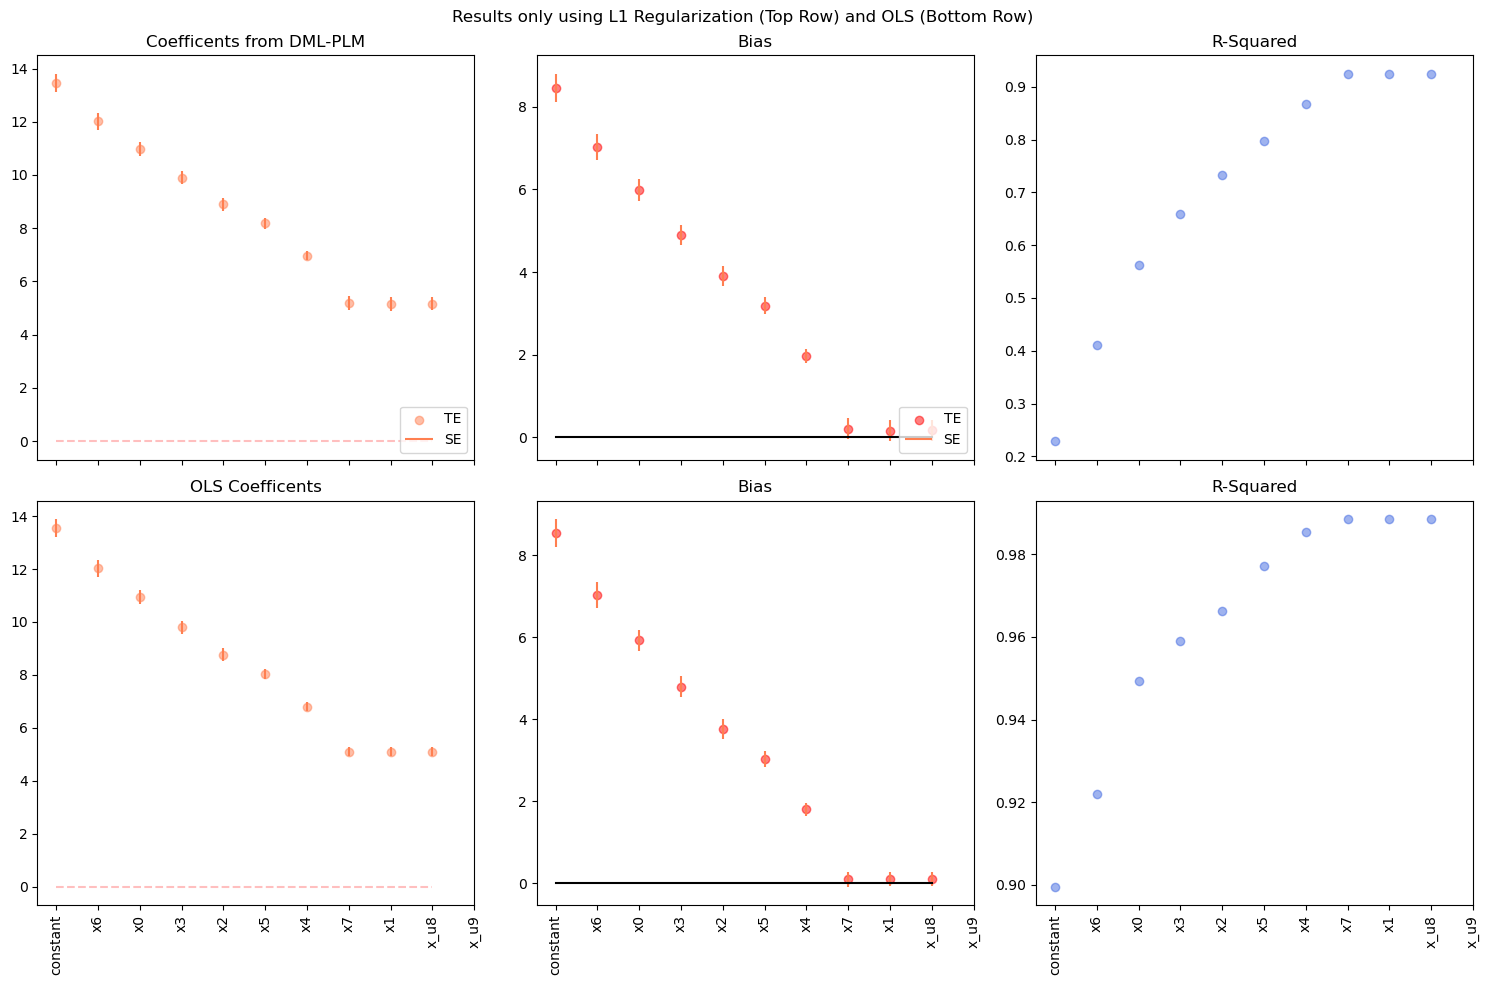

In [69]:

fig,ax = plt.subplots(ncols=3,  nrows=2, figsize=(15,10), sharex=True)
ax[0,0].scatter(range(len(outcome_feature_list)), iterative_ml_coeff, color='coral', alpha=0.5, label='TE')
ax[0,0].vlines( range(len(outcome_feature_list)), iterative_ml_coeff+1.96*iterative_ml_se, iterative_ml_coeff-1.96*iterative_ml_se, color='coral', label='SE')
ax[0,0].plot(range(len(outcome_feature_list)), np.zeros(len(outcome_feature_list)), alpha=0.25, color='red',linestyle='dashed',)
ax[0,0].set_title('Coefficents from DML-PLM')
ax[0,0].set_xticks(range(1+len(outcome_feature_list)))
ax[0,0].legend(loc='lower right')
ax[0,0].set_xticklabels(['constant']+outcome_feature_list, rotation=90)
# ax[0,0].set_ylim([-10,10])

ax[0,1].scatter(range(len(outcome_feature_list)), np.array(iterative_ml_coeff)-5, color='red', alpha=0.5, label='TE')
ax[0,1].vlines( range(len(outcome_feature_list)), iterative_ml_coeff+1.96*iterative_ml_se-5, iterative_ml_coeff-1.96*iterative_ml_se-5, color='coral', label='SE')
ax[0,1].plot(range(len(outcome_feature_list)), np.zeros(len(outcome_feature_list)), color='black')
ax[0,1].set_xticks(range(1+len(outcome_feature_list)))
ax[0,1].set_xticklabels(['constant']+outcome_feature_list, rotation=90)
ax[0,1].legend(loc='lower right')
ax[0,1].set_title('Bias')
# ax[0,1].set_ylim([-5,2])

ax[0,2].scatter(range(len(outcome_feature_list)), iterative_ml_rsquared, color='royalblue', alpha=0.5)
ax[0,2].set_title('R-Squared')
ax[0,2].set_xticks(range(1+len(outcome_feature_list)))
ax[0,2].set_xticklabels(['constant']+outcome_feature_list, rotation=90)
# ax[0,2].set_ylim([0.2,1.01])

ax[1,0].scatter(range(len(outcome_feature_list)), iterative_ols_coeff, color='coral', alpha=0.5)
ax[1,0].vlines( range(len(outcome_feature_list)), iterative_ols_coeff+1.96*iterative_ols_se, iterative_ols_coeff-1.96*iterative_ols_se, color='coral')
ax[1,0].plot(range(len(outcome_feature_list)), np.zeros(len(outcome_feature_list)), alpha=0.25, color='red',linestyle='dashed',)
ax[1,0].set_title('OLS Coefficents')
ax[1,0].set_xticks(range(1+len(outcome_feature_list)))
ax[1,0].set_xticklabels(['constant']+outcome_feature_list, rotation=90)
# ax[1,0].set_ylim([-10,10])

ax[1,1].scatter(range(len(outcome_feature_list)), np.array(iterative_ols_coeff)-5, color='red', alpha=0.5)
ax[1,1].vlines( range(len(outcome_feature_list)), iterative_ols_coeff+1.96*iterative_ols_se-5, iterative_ols_coeff-1.96*iterative_ols_se-5, color='coral')
ax[1,1].plot(range(len(outcome_feature_list)), np.zeros(len(outcome_feature_list)), color='black')
ax[1,1].set_xticks(range(1+len(outcome_feature_list)))
ax[1,1].set_xticklabels(['constant']+outcome_feature_list, rotation=90)
ax[1,1].set_title('Bias')
# ax[1,1].set_ylim([-5,2])

ax[1,2].scatter(range(len(outcome_feature_list)), iterative_ols_rsquared, color='royalblue', alpha=0.5)
ax[1,2].set_title('R-Squared')
ax[1,2].set_xticks(range(1+len(outcome_feature_list)))
ax[1,2].set_xticklabels(['constant']+outcome_feature_list, rotation=90)
# ax[1,2].set_ylim([0.2,1.01])

fig.suptitle('Results only using L1 Regularization (Top Row) and OLS (Bottom Row) ')
fig.tight_layout()
fig.patch.set_facecolor('white')

# Oster's Implementation
The problem with the analysis above is that it doesn't recognize that we may not observe certain features, which can cause bias. When we calculate the change in estimates as we include more and more coefficients, we are inherently extrapolating to performance when we see unobserved features.

So let's calculate this:
$$\delta^* =$$
$$ \dfrac{(\tilde{\beta} - \hat{\beta}) (\tilde{R} - \dot{R}) \hat{\sigma}^2_y \hat{\tau}_x + (\tilde{\beta} - \hat{\beta})\hat{\sigma}^2_x \hat{\tau}_x (\dot{\beta} - \tilde{\beta})^2 + 2A   }{(R_{max} - \tilde{R}) \hat{\sigma}^2_y (\dot{\beta} - \tilde{\beta})\hat{\sigma}^2_x + (\tilde{\beta} - \hat{\beta})(R_{max} - \tilde{R})\hat{\sigma}^2_y (\hat{\sigma}^2_x - \hat{\tau}_x) + A } $$

where $A=(\tilde{\beta}-\hat{\beta})^2 (\hat{\tau}_x (\dot{\beta}-\tilde{\beta})\hat{\sigma}^2_x ) + (\tilde{\beta}-\hat{\beta})^3(\hat{\tau}_x \hat{\sigma}^2_x - \hat{\tau}^2_x) $, 

and $\delta$ is the proportion of selection of observed and unobserved features. $\delta \frac{\sigma_{1x}}{\sigma^2_1} = \frac{\sigma_{2x}}{\sigma^2_2}$, and $\frac{\sigma_{1x}}{\sigma^2_1}$ is the coefficient of the variable of interest with observe and $\frac{\sigma_{2x}}{\sigma^2_2}$ is the same but with unobserved. This means that $\delta$ should be interpreted as the amount of selection on unobserved needed such that the estimate we have $\hat{\beta}$ becomes $\tilde{\beta}$.

The inputs for $\delta^*$ are:
- $\dot{\beta}$ is from regression $Y = \dot{\beta} X_{interest} $
- $\tilde{\beta}$ is from regression $Y = \dot{\beta} X_{interest} + f(X_{observed})$
- $\hat{\beta}$ [**user determined**] is from regression $Y = \dot{\beta} X_{interest} + f(X_{observed}, X_{unobserved})$
- $\hat{\sigma}^2_Y$ is the covariance of $Y$
- $\hat{\sigma}^2_X$ is the covariance of $X_{interest} $
- $\hat{\tau}_X$ is the variance of $(X_{interest} - \mathbb{E}[X_{interest} | X_{observed}] )$
- $R_{max}$ [**user determined**] is the maximum explain variance from including observed and unobserved.
- $\tilde{R}$ is the explained variation of observed
- $\dot{R}$ is the explained variation when you only have the feature of interest

In [70]:

def magic_delta_ml(df, W, y, 
                   beta_hat, R_max,
                  te_model, te_model_dict_inputs,
                y_model):    

    beta_dot = 0
    R_dot = 0
    beta_tilde = 0
    R_tilde= 0

    ## 1. Estimate regression on just W. 
    step1 = sm.OLS(df[y],sm.add_constant(df[W]) ).fit()        
    beta_dot = step1.params[1] 
    R_dot = step1.rsquared
    
    ## 2. Estimate regression on W and observed. Remember to use cross-fitting to get the correct R2    
    step2 = te_r2_output(te_model, te_model_dict_inputs,
                y_model)    
    beta_tilde = step2[0]
    R_tilde = step2[2]

    ## 3. calculate the expectation of W given the observed features
    random_partitions = 2
    df['splits'] = np.random.choice(random_partitions, len(df), replace=True)
    df.sort_values(by=['splits'], inplace=True)    
    W_hat = []
    for r in range(random_partitions):
        train = df.loc[df['splits']!=r]
        test = df.loc[df['splits']==r]
        
        model_on_train = te_model_dict_inputs['tmodel'].fit(sm.add_constant(train[te_model_dict_inputs['feature_name']]), 
                                                            train[W] )
        model_predict_test = model_on_train.predict_proba(sm.add_constant(test[te_model_dict_inputs['feature_name']]) )[:,1]
        W_hat.extend(model_predict_test)

        
    tau_x = np.var(np.array(df[W]) - W_hat)
    sigma_x = np.var(df[W])
    sigma_y = np.var(df[y])
    A = (beta_tilde - beta_hat)**2 * (tau_x *(beta_dot - beta_tilde)**2 * sigma_x) +\
        (beta_tilde-beta_hat)**3*(tau_x*sigma_x - tau_x**2)

    numerator = (beta_tilde-beta_hat)*(R_tilde - R_dot)*sigma_y*tau_x + (beta_tilde - beta_hat)*sigma_x*tau_x*(beta_dot - beta_tilde)**2
    numerator += 2*A

    denominator = (R_max-R_tilde)*sigma_y*(beta_dot - beta_tilde)*sigma_x + (beta_tilde-beta_hat)*(R_max - R_tilde)*sigma_y*(sigma_x - tau_x)
    denominator +=A
    return numerator / denominator

In [71]:
def magic_delta(df, W, y, obs_list, beta_hat, R_max):    
    random_partitions = 2
    df['splits'] = np.random.choice(random_partitions, len(df), replace=True)
    df.sort_values(by=['splits'], inplace=True)
    beta_dot = 0
    R_dot = 0
    beta_tilde = 0
    R_tilde= 0
    
    W_hat = []
    for r in range(random_partitions):
        train = df.loc[df['splits']!=r]
        test = df.loc[df['splits']==r]
        ## 1. Estimate regression on just W. Remember to use cross-fitting to get the correct R2
        model_on_train = sm.OLS(train[y],sm.add_constant(train[W]) ).fit()        
        model_predict_test = model_on_train.predict(sm.add_constant(test[W]) )        
        beta_dot += model_on_train.params[1] / random_partitions
        R_dot += np.sqrt(np.corrcoef( model_predict_test, test[y])[0,1]) / random_partitions

        ## 2. Estimate regression on W and observed. Remember to use cross-fitting to get the correct R2
        model_on_train = sm.OLS(train[y],sm.add_constant(train[[W] + obs_list]) ).fit()        
        model_predict_test = model_on_train.predict(sm.add_constant(test[[W] + obs_list]) )        
        beta_tilde += model_on_train.params[1] / random_partitions
        R_tilde += np.sqrt(np.corrcoef( model_predict_test, test[y])[0,1]) / random_partitions

        ## 3. calculate the expectation of W given the observed features
        model_on_train = sm.OLS(train[W],sm.add_constant(train[obs_list]) ).fit()        
        model_predict_test = model_on_train.predict(sm.add_constant(test[obs_list]) )        
        W_hat.extend(model_predict_test.to_list())

    tau_x = np.var(np.array(df[W]) - W_hat)
    sigma_x = np.var(df[W])
    sigma_y = np.var(df[y])
    A = (beta_tilde - beta_hat)**2 * (tau_x *(beta_dot - beta_tilde)**2 * sigma_x) +\
        (beta_tilde-beta_hat)**3*(tau_x*sigma_x - tau_x**2)

    numerator = (beta_tilde-beta_hat)*(R_tilde - R_dot)*sigma_y*tau_x + (beta_tilde - beta_hat)*sigma_x*tau_x*(beta_dot - beta_tilde)**2
    numerator += 2*A

    denominator = (R_max-R_tilde)*sigma_y*(beta_dot - beta_tilde)*sigma_x + (beta_tilde-beta_hat)*(R_max - R_tilde)*sigma_y*(sigma_x - tau_x)
    denominator +=A
    return numerator / denominator

In [78]:
'''
Now calculate this for different combinations of observed/controlling features
'''
ymodel = LassoCV(normalize=True, n_jobs=-1, max_iter= 5000)
tmodel = LogisticRegressionCV(n_jobs=-1, penalty='l1', solver='saga', max_iter= 5000)
te_model_dict_inputs = {
    'data_est': df,
    'split_name': 'splits',
    'n_data_splits': 5,
    'feature_name': feature_list,
    'outcome_name': 'Y',
    'treatment_name': 'T',
    'ymodel':ymodel,
    'tmodel':tmodel,
    'aux_dictionary': {'lower':0.001, 'upper': 0.999}
}


iterative_list = []
iterative_coeff = []
iterative_se = []
iterative_rsquared = []
iterative_delta = []


iterative_ml_list = []
iterative_ml_coeff = []
iterative_ml_se = []
iterative_ml_rsquared = []
iterative_delta_ml = []



for f in outcome_feature_list:
    ## Regular OLS models
    
    iterative_list.append(f)
    a = ols_output(iterative_list)
    iterative_coeff.append(a[0])
    iterative_se.append(a[1])
    iterative_rsquared.append(a[2])
    
    d = magic_delta(df, 'T', 'Y', iterative_list , 0, 1)
    iterative_delta.append(d)

    
    ## ML models
    iterative_ml_list.append(f)
    te_model_dict_inputs['feature_name'] = iterative_ml_list
    a = te_r2_output(st.ate.dml.dml_plm, te_model_dict_inputs,
                    ymodel)
    iterative_ml_coeff.append(a[0])
    iterative_ml_se.append(a[1])
    iterative_ml_rsquared.append(a[2])
    
    d = magic_delta_ml(df, 'T', 'Y', 
                   0, 1,
                  st.ate.dml.dml_plm, te_model_dict_inputs,
                ymodel)
    iterative_delta_ml.append(d)    

    
iterative_coeff = np.array(iterative_coeff)
iterative_se = np.array(iterative_se)
iterative_rsquared = np.array(iterative_rsquared)
iterative_delta = np.array(iterative_delta)


C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

f

C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

f

C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

f

C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

f

C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

f

C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

f

C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

f

C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

f

C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

f

C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

f

C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

f

C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

f

C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

f

C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

f

C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

f

C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

f

C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\hjuli\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

f

In [79]:
iterative_ml_coeff = np.array(iterative_ml_coeff)
iterative_ml_se = np.array(iterative_ml_se)
iterative_ml_rsquared = np.array(iterative_ml_rsquared)
iterative_delta_ml = np.array(iterative_delta_ml)


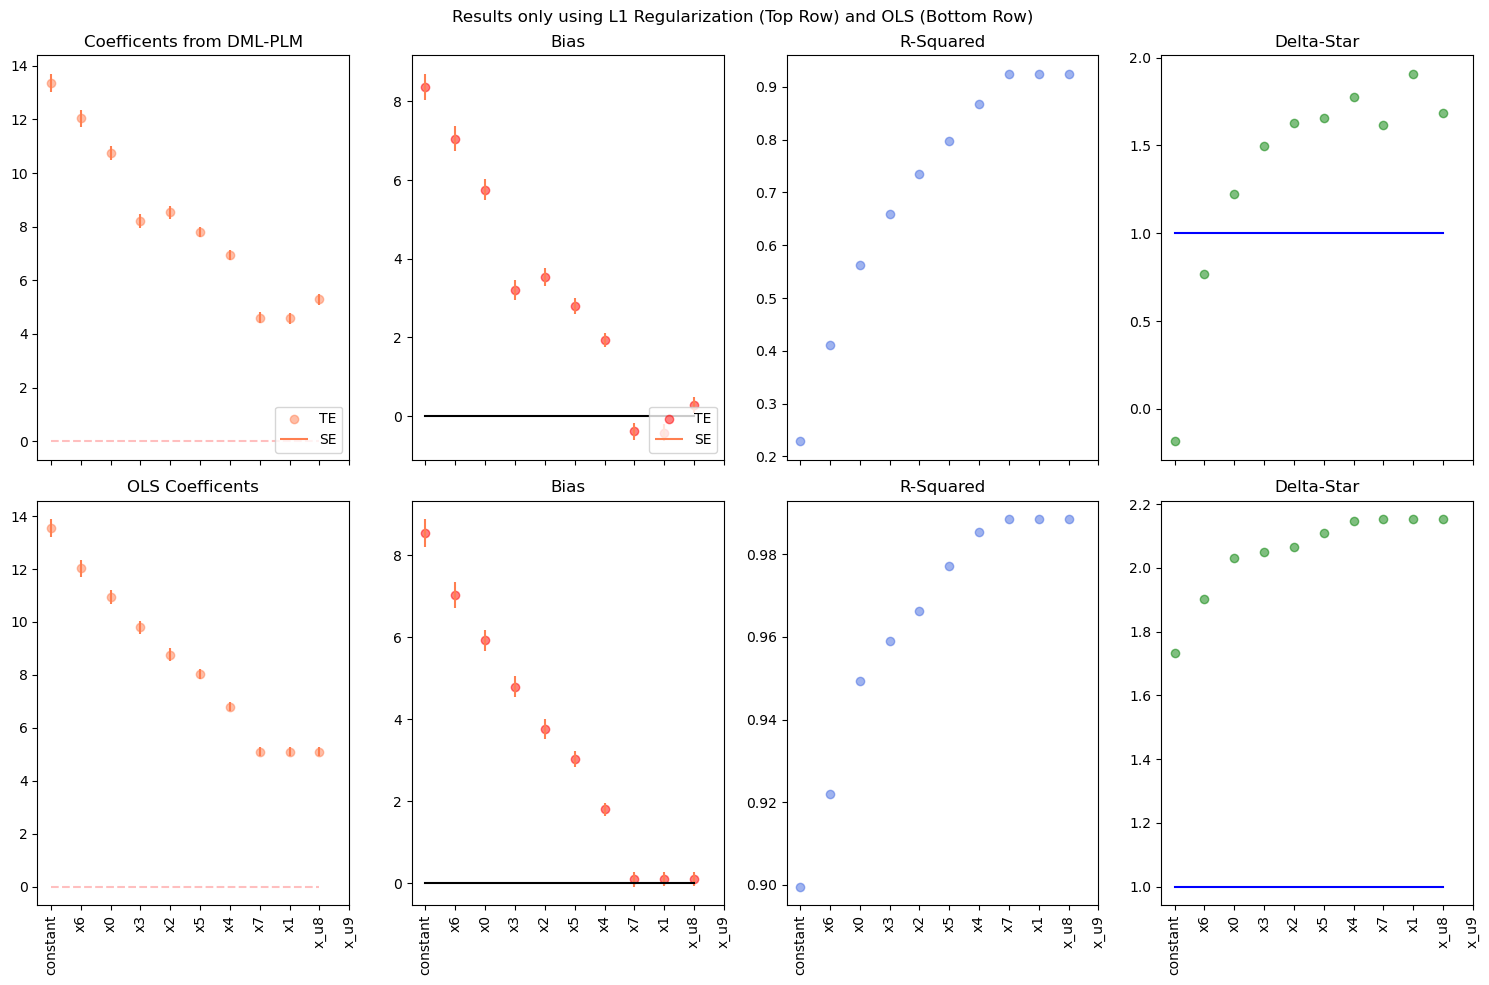

In [80]:

fig,ax = plt.subplots(ncols=4,  nrows=2, figsize=(15,10), sharex=True)
ax[0,0].scatter(range(len(outcome_feature_list)), iterative_ml_coeff, color='coral', alpha=0.5, label='TE')
ax[0,0].vlines( range(len(outcome_feature_list)), iterative_ml_coeff+1.96*iterative_ml_se, iterative_ml_coeff-1.96*iterative_ml_se, color='coral', label='SE')
ax[0,0].plot(range(len(outcome_feature_list)), np.zeros(len(outcome_feature_list)), alpha=0.25, color='red',linestyle='dashed',)
ax[0,0].set_title('Coefficents from DML-PLM')
ax[0,0].set_xticks(range(1+len(outcome_feature_list)))
ax[0,0].legend(loc='lower right')
ax[0,0].set_xticklabels(['constant']+outcome_feature_list, rotation=90)
# ax[0,0].set_ylim([-10,10])

ax[0,1].scatter(range(len(outcome_feature_list)), np.array(iterative_ml_coeff)-5, color='red', alpha=0.5, label='TE')
ax[0,1].vlines( range(len(outcome_feature_list)), iterative_ml_coeff+1.96*iterative_ml_se-5, iterative_ml_coeff-1.96*iterative_ml_se-5, color='coral', label='SE')
ax[0,1].plot(range(len(outcome_feature_list)), np.zeros(len(outcome_feature_list)), color='black')
ax[0,1].set_xticks(range(1+len(outcome_feature_list)))
ax[0,1].set_xticklabels(['constant']+outcome_feature_list, rotation=90)
ax[0,1].legend(loc='lower right')
ax[0,1].set_title('Bias')
# ax[0,1].set_ylim([-5,2])

ax[0,2].scatter(range(len(outcome_feature_list)), iterative_ml_rsquared, color='royalblue', alpha=0.5)
ax[0,2].set_title('R-Squared')
ax[0,2].set_xticks(range(1+len(outcome_feature_list)))
ax[0,2].set_xticklabels(['constant']+outcome_feature_list, rotation=90)
# ax[0,2].set_ylim([0.2,1.01])

ax[0,3].scatter(range(len(outcome_feature_list)), iterative_delta_ml, color='green', alpha=0.5)
ax[0,3].plot(range(len(outcome_feature_list)), np.ones(len(outcome_feature_list)), color='blue')
ax[0,3].set_title('Delta-Star')
ax[0,3].set_xticks(range(1+len(outcome_feature_list)))
ax[0,3].set_xticklabels(['constant']+outcome_feature_list, rotation=90)



ax[1,0].scatter(range(len(outcome_feature_list)), iterative_ols_coeff, color='coral', alpha=0.5)
ax[1,0].vlines( range(len(outcome_feature_list)), iterative_ols_coeff+1.96*iterative_ols_se, iterative_ols_coeff-1.96*iterative_ols_se, color='coral')
ax[1,0].plot(range(len(outcome_feature_list)), np.zeros(len(outcome_feature_list)), alpha=0.25, color='red',linestyle='dashed',)
ax[1,0].set_title('OLS Coefficents')
ax[1,0].set_xticks(range(1+len(outcome_feature_list)))
ax[1,0].set_xticklabels(['constant']+outcome_feature_list, rotation=90)
# ax[1,0].set_ylim([-10,10])

ax[1,1].scatter(range(len(outcome_feature_list)), np.array(iterative_ols_coeff)-5, color='red', alpha=0.5)
ax[1,1].vlines( range(len(outcome_feature_list)), iterative_ols_coeff+1.96*iterative_ols_se-5, iterative_ols_coeff-1.96*iterative_ols_se-5, color='coral')
ax[1,1].plot(range(len(outcome_feature_list)), np.zeros(len(outcome_feature_list)), color='black')
ax[1,1].set_xticks(range(1+len(outcome_feature_list)))
ax[1,1].set_xticklabels(['constant']+outcome_feature_list, rotation=90)
ax[1,1].set_title('Bias')
# ax[1,1].set_ylim([-5,2])

ax[1,2].scatter(range(len(outcome_feature_list)), iterative_ols_rsquared, color='royalblue', alpha=0.5)
ax[1,2].set_title('R-Squared')
ax[1,2].set_xticks(range(1+len(outcome_feature_list)))
ax[1,2].set_xticklabels(['constant']+outcome_feature_list, rotation=90)
# ax[1,2].set_ylim([0.2,1.01])


ax[1,3].scatter(range(len(outcome_feature_list)), iterative_delta, color='green', alpha=0.5)
ax[1,3].plot(range(len(outcome_feature_list)), np.ones(len(outcome_feature_list)), color='blue')
ax[1,3].set_title('Delta-Star')
ax[1,3].set_xticks(range(1+len(outcome_feature_list)))
ax[1,3].set_xticklabels(['constant']+outcome_feature_list, rotation=90)


fig.suptitle('Results only using L1 Regularization (Top Row) and OLS (Bottom Row) ')
fig.tight_layout()
fig.patch.set_facecolor('white')

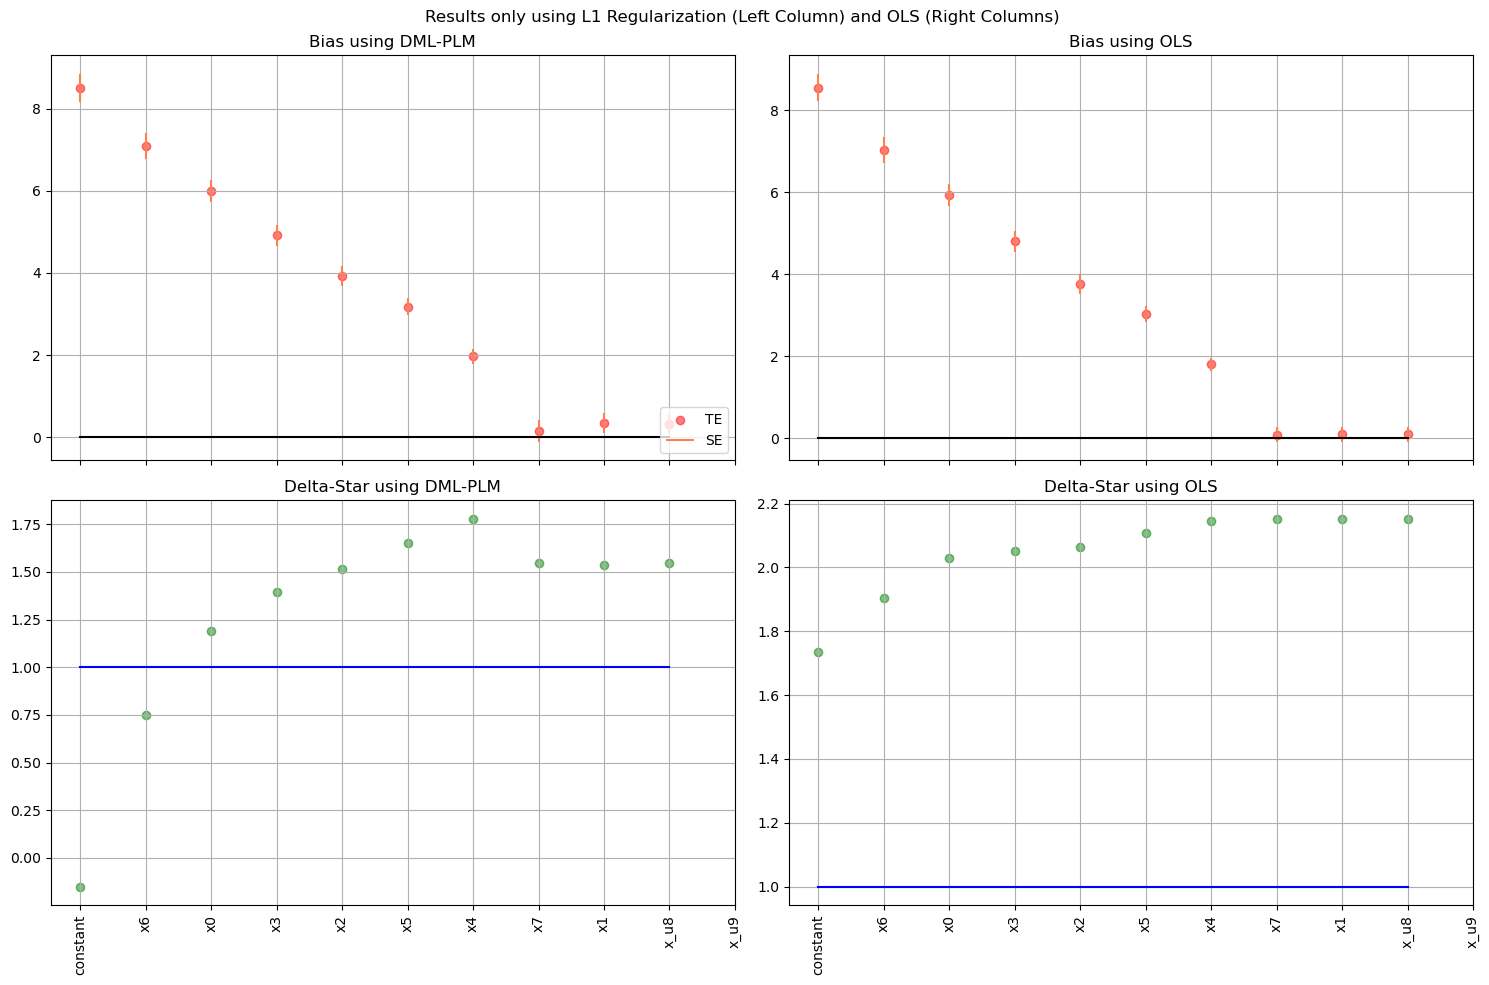

In [77]:

fig,ax = plt.subplots(ncols=2,  nrows=2, figsize=(15,10), sharex=True)

ax[0,0].scatter(range(len(outcome_feature_list)), np.array(iterative_ml_coeff)-5, color='red', alpha=0.5, label='TE')
ax[0,0].vlines( range(len(outcome_feature_list)), iterative_ml_coeff+1.96*iterative_ml_se-5, iterative_ml_coeff-1.96*iterative_ml_se-5, color='coral', label='SE')
ax[0,0].plot(range(len(outcome_feature_list)), np.zeros(len(outcome_feature_list)), color='black')
ax[0,0].set_xticks(range(1+len(outcome_feature_list)))
ax[0,0].set_xticklabels(['constant']+outcome_feature_list, rotation=90)
ax[0,0].legend(loc='lower right')
ax[0,0].set_title('Bias using DML-PLM')
# ax[0,0].set_ylim([-10,2])
ax[0,0].grid()

ax[0,1].scatter(range(len(outcome_feature_list)), np.array(iterative_ols_coeff)-5, color='red', alpha=0.5)
ax[0,1].vlines( range(len(outcome_feature_list)), iterative_ols_coeff+1.96*iterative_ols_se-5, iterative_ols_coeff-1.96*iterative_ols_se-5, color='coral')
ax[0,1].plot(range(len(outcome_feature_list)), np.zeros(len(outcome_feature_list)), color='black')
ax[0,1].set_xticks(range(1+len(outcome_feature_list)))
ax[0,1].set_xticklabels(['constant']+outcome_feature_list, rotation=90)
ax[0,1].set_title('Bias using OLS')
# ax[0,1].set_ylim([-10,2])
ax[0,1].grid()

ax[1,0].scatter(range(len(outcome_feature_list)), iterative_delta_ml, color='green', alpha=0.5)
ax[1,0].plot(range(len(outcome_feature_list)), np.ones(len(outcome_feature_list)), color='blue')
ax[1,0].set_title('Delta-Star using DML-PLM')
ax[1,0].set_xticks(range(1+len(outcome_feature_list)))
ax[1,0].set_xticklabels(['constant']+outcome_feature_list, rotation=90)
ax[1,0].grid()


ax[1,1].scatter(range(len(outcome_feature_list)), iterative_delta, color='green', alpha=0.5)
ax[1,1].plot(range(len(outcome_feature_list)), np.ones(len(outcome_feature_list)), color='blue')
ax[1,1].set_title('Delta-Star using OLS')
ax[1,1].set_xticks(range(1+len(outcome_feature_list)))
ax[1,1].set_xticklabels(['constant']+outcome_feature_list, rotation=90)
ax[1,1].grid()


fig.suptitle('Results only using L1 Regularization (Left Column) and OLS (Right Columns) ')
fig.tight_layout()
fig.patch.set_facecolor('white')